In [1]:
# take 10% of images from each class to validation

In [2]:
# there are B&W images in data!

In [3]:
import os
from datetime import datetime
from typing import Tuple
from time import monotonic

# from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
num_cpus = os.cpu_count()
half_cpus = num_cpus // 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Data

In [4]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [6]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [7]:
print(len(train_split + val_split))
# print(train_split[0])
# print(len(train_split), len(val_split))

100000


In [8]:
# TODO ? why and what we are doing by T.Normalize
# Normalization values for mean and std based on data
from xml.dom.expatbuilder import theDOMImplementation


temp_dataset = TinyImageNetDataset(source_folder, train_split + val_split, transform=T.ToTensor())
temp_dataloader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=half_cpus)
mean = torch.zeros(3).to(DEVICE)
std = torch.zeros(3).to(DEVICE)
n_samples = 0

# Iterate through the dataset
for images, _ in temp_dataloader:
    images = images.to(DEVICE)
    # Reshape images to (batch_size, 3, height, width)
    images = images.view(images.size(0), images.size(1), -1)
    n_samples += images.size(0)
    
    # Sum up the pixel values for each channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Calculate the mean and standard deviation
mean /= n_samples
std /= n_samples

mean = mean.cpu()
std = std.cpu()

print(f'Mean: {mean}')
print(f'Std: {std}')

train_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

Mean: tensor([0.4802, 0.4481, 0.3975])
Std: tensor([0.2296, 0.2263, 0.2255])


In [9]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [10]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [11]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [12]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [13]:
class CnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, *args, n_conv_layers = 1):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  padding=kernel_size // 2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    ]

    for _ in range(n_conv_layers - 1):
        layers.append(nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(out_channels))

    self.conv_layers = nn.Sequential(*layers)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.pool(x)
    return x


class FcBlock(nn.Module):
    def __init__(self, in_shape: int, 
                 out_shape: int, 
                 do_batchnorm: bool = True, 
                 activation: nn.Module = None):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_shape, out_shape))
        
        if activation is not None:
            layers.append(activation)

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(out_shape))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [14]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [15]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CnnBlock(3, 64, kernel_size=5, n_conv_layers=2)
        self.conv2 = CnnBlock(64, 128, kernel_size=5, n_conv_layers=2)
        self.conv3 = CnnBlock(128, 256, kernel_size=3, n_conv_layers=2)
        self.conv4 = CnnBlock(256, 32, kernel_size=1)

        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = FcBlock(32 * 4 * 4, 512, do_batchnorm=True, activation=nn.ReLU())
        
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(512, 200, do_batchnorm=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [16]:
model = BaselineModel()

out = model(X)
out.shape

torch.Size([128, 200])

---

### Train

In [17]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE

In [18]:
set_seed(123)

model = BaselineModel()
model.to(DEVICE)

Random seed set as 123


BaselineModel(
  (conv1): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_s

In [19]:
train_config = {
    'n_epochs': 25,
    'lr': 0.005,
    'batch_size': 64,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'])
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

In [20]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    
    return avg_loss, accuracy

In [21]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X)
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [22]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------
[22:48:45] Step 20/1407: train loss = 5.5455
[22:48:46] Step 40/1407: train loss = 5.45536
[22:48:47] Step 60/1407: train loss = 5.37826
[22:48:47] Step 80/1407: train loss = 5.31624
[22:48:48] Step 100/1407: train loss = 5.26014
[22:48:49] Step 120/1407: train loss = 5.21868
[22:48:50] Step 140/1407: train loss = 5.17848
[22:48:51] Step 160/1407: train loss = 5.1452
[22:48:52] Step 180/1407: train loss = 5.11952
[22:48:52] Step 200/1407: train loss = 5.09403
[22:48:53] Step 220/1407: train loss = 5.06976
[22:48:54] Step 240/1407: train loss = 5.04128
[22:48:55] Step 260/1407: train loss = 5.01551
[22:48:56] Step 280/1407: train loss = 4.99398
[22:48:57] Step 300/1407: train loss = 4.97377
[22:48:57] Step 320/1407: train loss = 4.95578
[22:48:58] Step 340/1407: train loss = 4.93589
[22:48:59] Step 360/1407: train loss = 4.91904
[22:49:00] Step 380/1407: train loss = 4.9022
[22:49:01] Step 400/1407: train loss =

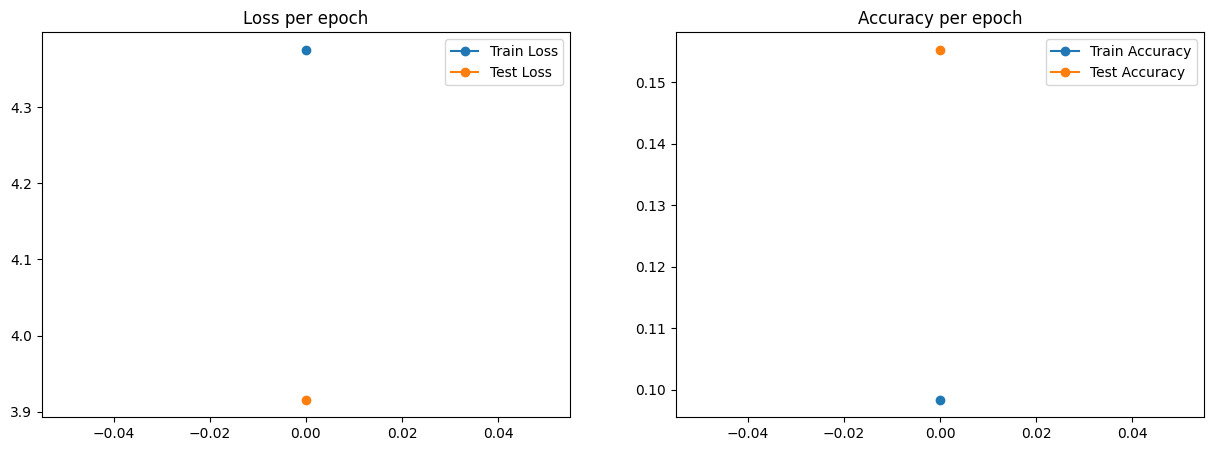

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[22:49:48] Step 20/1407: train loss = 3.84369
[22:49:49] Step 40/1407: train loss = 3.85738
[22:49:49] Step 60/1407: train loss = 3.84025
[22:49:50] Step 80/1407: train loss = 3.82341
[22:49:51] Step 100/1407: train loss = 3.83353
[22:49:52] Step 120/1407: train loss = 3.82769
[22:49:53] Step 140/1407: train loss = 3.82703
[22:49:54] Step 160/1407: train loss = 3.82583
[22:49:54] Step 180/1407: train loss = 3.82306
[22:49:55] Step 200/1407: train loss = 3.81629
[22:49:56] Step 220/1407: train loss = 3.81562
[22:49:57] Step 240/1407: train loss = 3.81141
[22:49:58] Step 260/1407: train loss = 3.79519
[22:49:59] Step 280/1407: train loss = 3.79352
[22:49:59] Step 300/1407: train loss = 3.78917
[22:50:00] Step 320/1407: train loss = 3.78834
[22:50:01] Step 340/1407: train loss = 3.78683
[22:50:02] Step 360/1407: train loss = 3.78422
[22:50:03] Step 380/1407: train loss = 3.7778
[22:50:03] Step 40

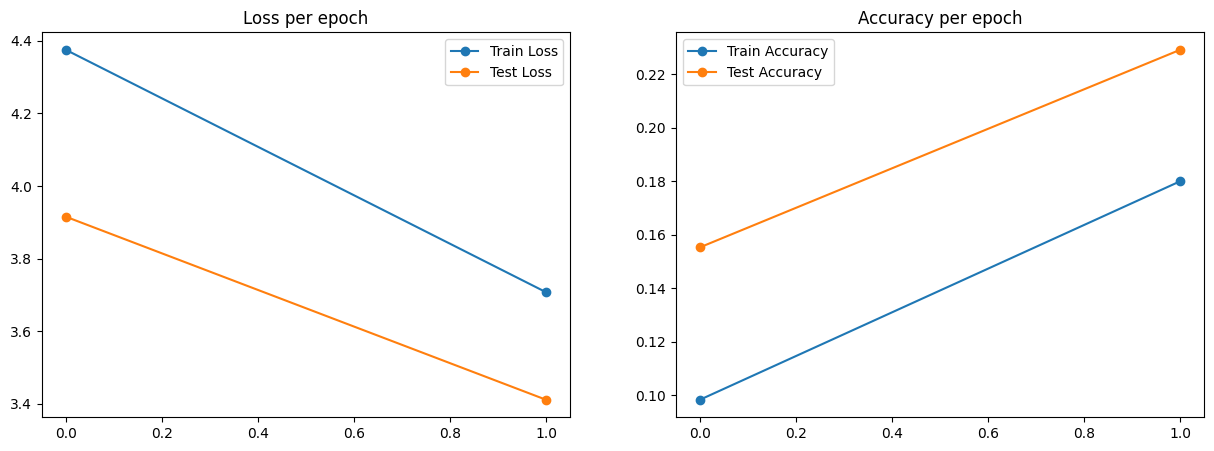

Saving best model

 		 ------------------------------ EPOCH: 3 ------------------------------
[22:50:50] Step 20/1407: train loss = 3.46005
[22:50:51] Step 40/1407: train loss = 3.54366
[22:50:52] Step 60/1407: train loss = 3.5917
[22:50:53] Step 80/1407: train loss = 3.58734
[22:50:54] Step 100/1407: train loss = 3.562
[22:50:54] Step 120/1407: train loss = 3.56015
[22:50:55] Step 140/1407: train loss = 3.54594
[22:50:56] Step 160/1407: train loss = 3.53224
[22:50:57] Step 180/1407: train loss = 3.52192
[22:50:58] Step 200/1407: train loss = 3.52709
[22:50:59] Step 220/1407: train loss = 3.51651
[22:50:59] Step 240/1407: train loss = 3.51189
[22:51:00] Step 260/1407: train loss = 3.50542
[22:51:01] Step 280/1407: train loss = 3.50116
[22:51:02] Step 300/1407: train loss = 3.49777
[22:51:03] Step 320/1407: train loss = 3.49442
[22:51:03] Step 340/1407: train loss = 3.49092
[22:51:04] Step 360/1407: train loss = 3.4872
[22:51:05] Step 380/1407: train loss = 3.48525
[22:51:06] Step 400/1

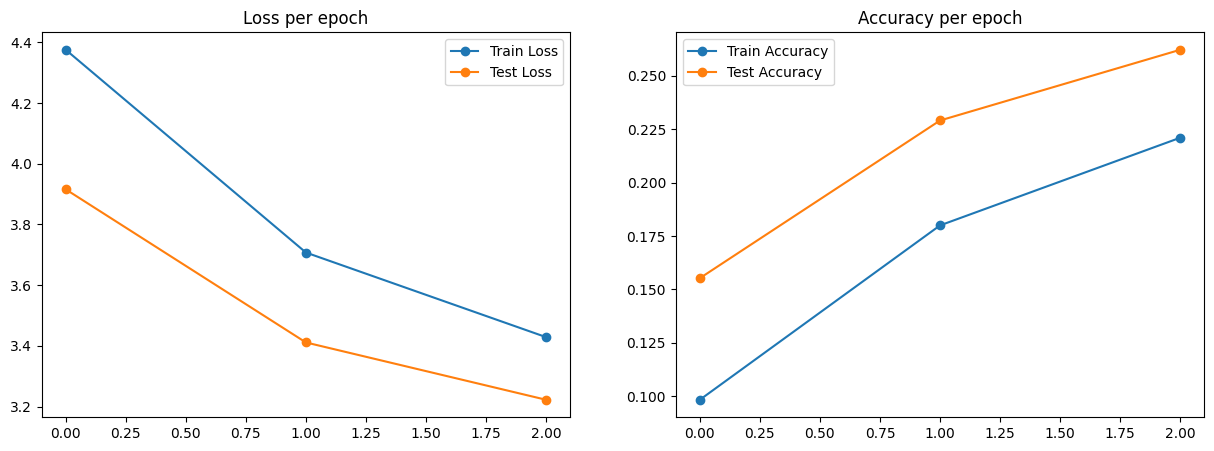

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[22:51:52] Step 20/1407: train loss = 3.23594
[22:51:53] Step 40/1407: train loss = 3.23146
[22:51:54] Step 60/1407: train loss = 3.19497
[22:51:55] Step 80/1407: train loss = 3.23452
[22:51:56] Step 100/1407: train loss = 3.22371
[22:51:56] Step 120/1407: train loss = 3.22279
[22:51:57] Step 140/1407: train loss = 3.22304
[22:51:58] Step 160/1407: train loss = 3.21734
[22:51:59] Step 180/1407: train loss = 3.21673
[22:52:00] Step 200/1407: train loss = 3.21601
[22:52:00] Step 220/1407: train loss = 3.22271
[22:52:01] Step 240/1407: train loss = 3.22114
[22:52:02] Step 260/1407: train loss = 3.22324
[22:52:03] Step 280/1407: train loss = 3.22753
[22:52:04] Step 300/1407: train loss = 3.23683
[22:52:05] Step 320/1407: train loss = 3.24187
[22:52:05] Step 340/1407: train loss = 3.23993
[22:52:06] Step 360/1407: train loss = 3.24098
[22:52:07] Step 380/1407: train loss = 3.24614
[22:52:08] Step 4

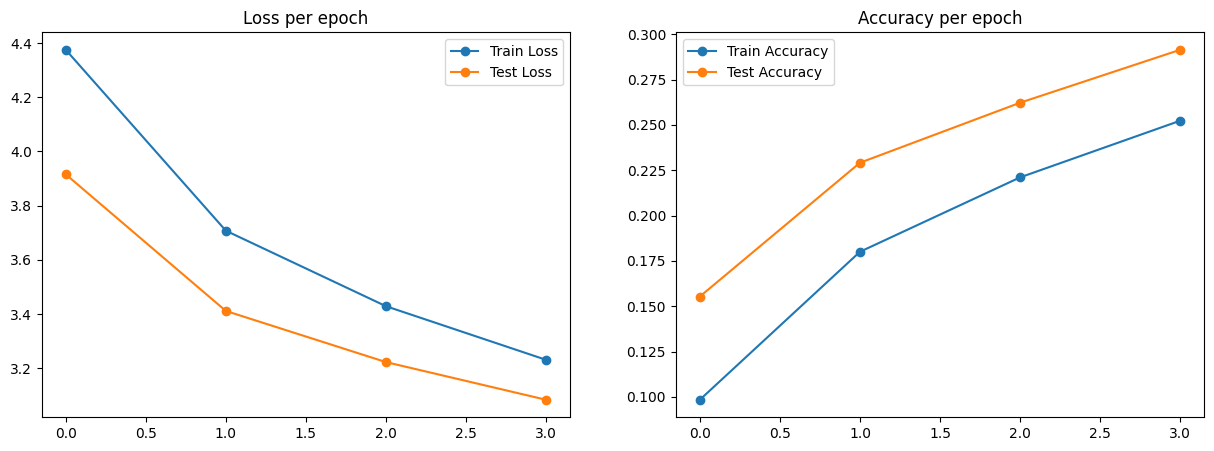

Saving best model

 		 ------------------------------ EPOCH: 5 ------------------------------
[22:52:53] Step 20/1407: train loss = 3.04287
[22:52:54] Step 40/1407: train loss = 3.06142
[22:52:55] Step 60/1407: train loss = 3.03532
[22:52:56] Step 80/1407: train loss = 3.05414
[22:52:57] Step 100/1407: train loss = 3.03125
[22:52:57] Step 120/1407: train loss = 3.03403
[22:52:58] Step 140/1407: train loss = 3.03876
[22:52:59] Step 160/1407: train loss = 3.04882
[22:53:00] Step 180/1407: train loss = 3.04448
[22:53:01] Step 200/1407: train loss = 3.05005
[22:53:01] Step 220/1407: train loss = 3.04662
[22:53:02] Step 240/1407: train loss = 3.04687
[22:53:03] Step 260/1407: train loss = 3.04716
[22:53:04] Step 280/1407: train loss = 3.04784
[22:53:05] Step 300/1407: train loss = 3.05445
[22:53:05] Step 320/1407: train loss = 3.05033
[22:53:06] Step 340/1407: train loss = 3.05308
[22:53:07] Step 360/1407: train loss = 3.05389
[22:53:08] Step 380/1407: train loss = 3.05979
[22:53:08] Step 4

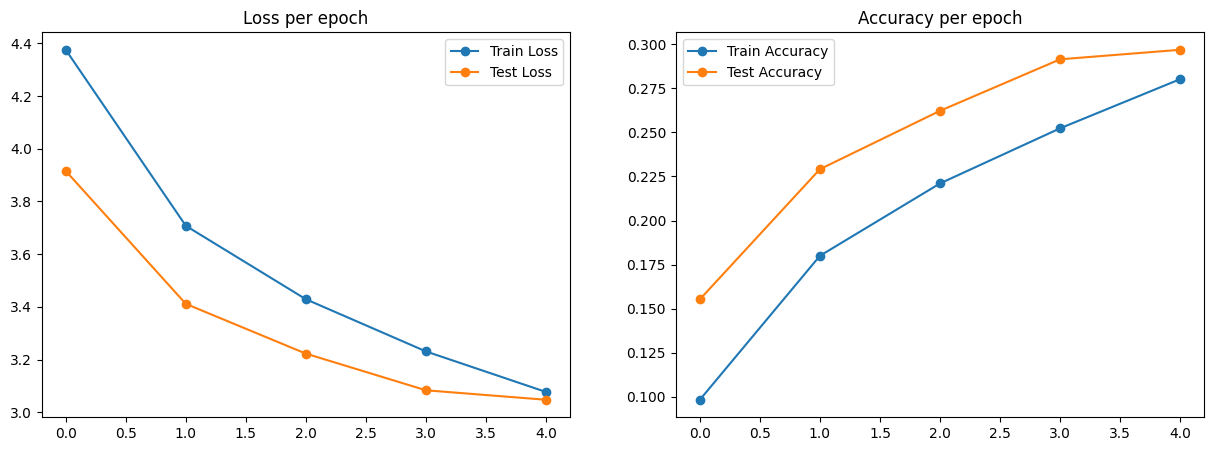

Saving best model

 		 ------------------------------ EPOCH: 6 ------------------------------
[22:53:55] Step 20/1407: train loss = 2.8877
[22:53:56] Step 40/1407: train loss = 2.88431
[22:53:56] Step 60/1407: train loss = 2.88946
[22:53:57] Step 80/1407: train loss = 2.8913
[22:53:58] Step 100/1407: train loss = 2.90032
[22:53:59] Step 120/1407: train loss = 2.90756
[22:54:00] Step 140/1407: train loss = 2.90907
[22:54:01] Step 160/1407: train loss = 2.92177
[22:54:01] Step 180/1407: train loss = 2.90759
[22:54:02] Step 200/1407: train loss = 2.90703
[22:54:03] Step 220/1407: train loss = 2.90902
[22:54:04] Step 240/1407: train loss = 2.90678
[22:54:05] Step 260/1407: train loss = 2.90355
[22:54:05] Step 280/1407: train loss = 2.90572
[22:54:06] Step 300/1407: train loss = 2.90749
[22:54:07] Step 320/1407: train loss = 2.91061
[22:54:08] Step 340/1407: train loss = 2.909
[22:54:09] Step 360/1407: train loss = 2.91354
[22:54:10] Step 380/1407: train loss = 2.91055
[22:54:10] Step 400/1

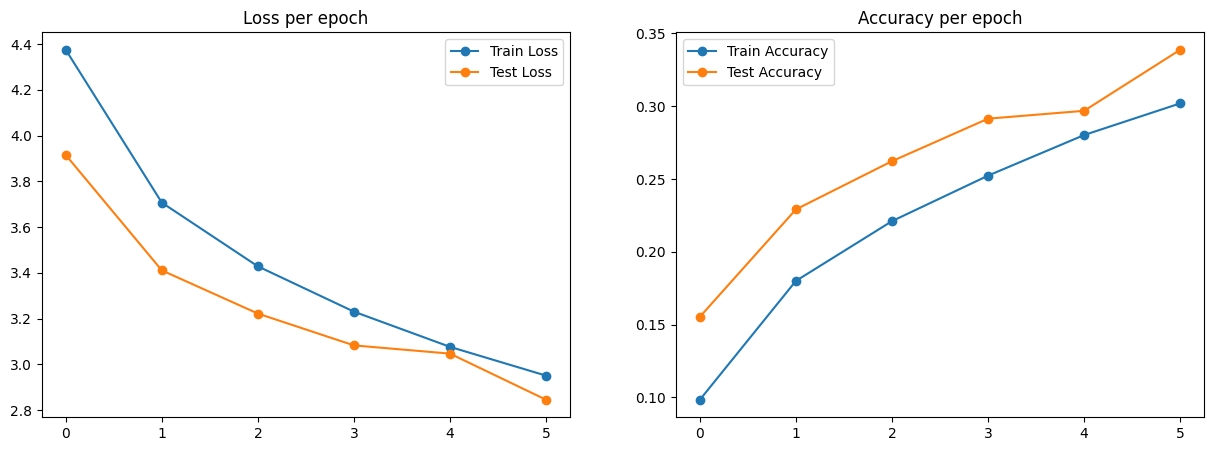

Saving best model

 		 ------------------------------ EPOCH: 7 ------------------------------
[22:54:57] Step 20/1407: train loss = 2.84106
[22:54:57] Step 40/1407: train loss = 2.81371
[22:54:58] Step 60/1407: train loss = 2.81933
[22:54:59] Step 80/1407: train loss = 2.81208
[22:55:00] Step 100/1407: train loss = 2.80392
[22:55:01] Step 120/1407: train loss = 2.80114
[22:55:01] Step 140/1407: train loss = 2.7956
[22:55:02] Step 160/1407: train loss = 2.79278
[22:55:03] Step 180/1407: train loss = 2.79602
[22:55:04] Step 200/1407: train loss = 2.79333
[22:55:05] Step 220/1407: train loss = 2.80204
[22:55:05] Step 240/1407: train loss = 2.80233
[22:55:06] Step 260/1407: train loss = 2.80169
[22:55:07] Step 280/1407: train loss = 2.80382
[22:55:08] Step 300/1407: train loss = 2.80874
[22:55:08] Step 320/1407: train loss = 2.80821
[22:55:09] Step 340/1407: train loss = 2.81161
[22:55:10] Step 360/1407: train loss = 2.81152
[22:55:11] Step 380/1407: train loss = 2.81495
[22:55:12] Step 40

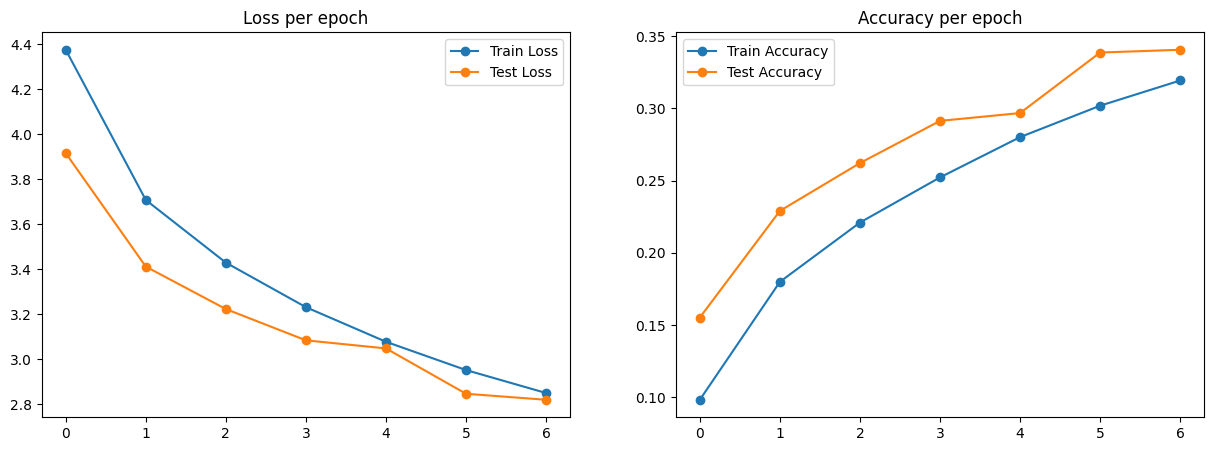

Saving best model

 		 ------------------------------ EPOCH: 8 ------------------------------
[22:55:58] Step 20/1407: train loss = 2.69828
[22:55:59] Step 40/1407: train loss = 2.64231
[22:55:59] Step 60/1407: train loss = 2.65534
[22:56:00] Step 80/1407: train loss = 2.70523
[22:56:01] Step 100/1407: train loss = 2.72194
[22:56:02] Step 120/1407: train loss = 2.72773
[22:56:03] Step 140/1407: train loss = 2.73925
[22:56:03] Step 160/1407: train loss = 2.73681
[22:56:04] Step 180/1407: train loss = 2.74945
[22:56:05] Step 200/1407: train loss = 2.74346
[22:56:06] Step 220/1407: train loss = 2.7375
[22:56:07] Step 240/1407: train loss = 2.73678
[22:56:08] Step 260/1407: train loss = 2.73639
[22:56:08] Step 280/1407: train loss = 2.74193
[22:56:09] Step 300/1407: train loss = 2.74006
[22:56:10] Step 320/1407: train loss = 2.73652
[22:56:11] Step 340/1407: train loss = 2.73184
[22:56:12] Step 360/1407: train loss = 2.7257
[22:56:12] Step 380/1407: train loss = 2.72354
[22:56:13] Step 400

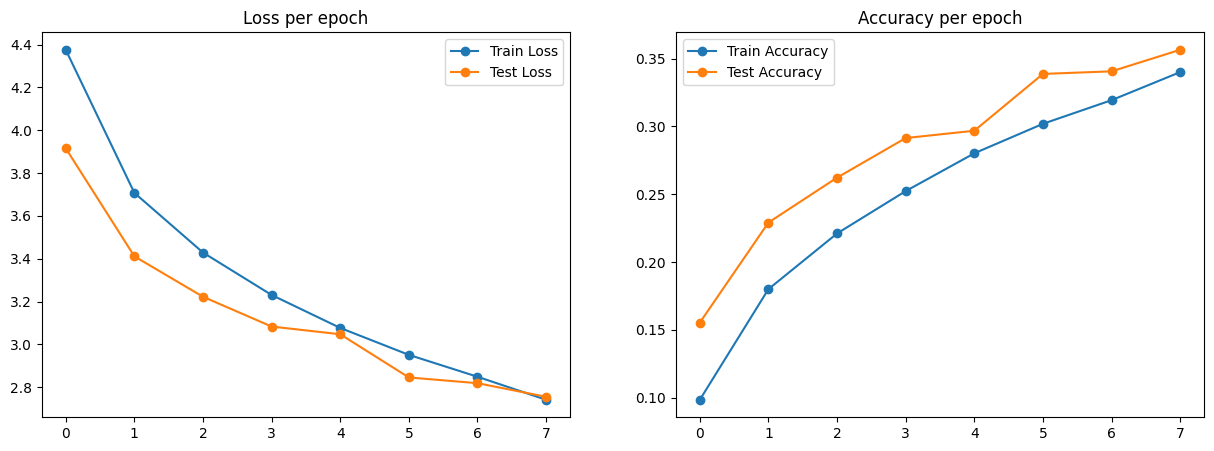

Saving best model

 		 ------------------------------ EPOCH: 9 ------------------------------
[22:56:59] Step 20/1407: train loss = 2.53841
[22:57:00] Step 40/1407: train loss = 2.52421
[22:57:01] Step 60/1407: train loss = 2.5272
[22:57:02] Step 80/1407: train loss = 2.54521
[22:57:02] Step 100/1407: train loss = 2.54978
[22:57:03] Step 120/1407: train loss = 2.56589
[22:57:04] Step 140/1407: train loss = 2.56336
[22:57:05] Step 160/1407: train loss = 2.56836
[22:57:06] Step 180/1407: train loss = 2.56238
[22:57:07] Step 200/1407: train loss = 2.56781
[22:57:07] Step 220/1407: train loss = 2.5655
[22:57:08] Step 240/1407: train loss = 2.5734
[22:57:09] Step 260/1407: train loss = 2.57367
[22:57:10] Step 280/1407: train loss = 2.58183
[22:57:11] Step 300/1407: train loss = 2.58203
[22:57:11] Step 320/1407: train loss = 2.5835
[22:57:12] Step 340/1407: train loss = 2.58775
[22:57:13] Step 360/1407: train loss = 2.58894
[22:57:14] Step 380/1407: train loss = 2.58831
[22:57:15] Step 400/1

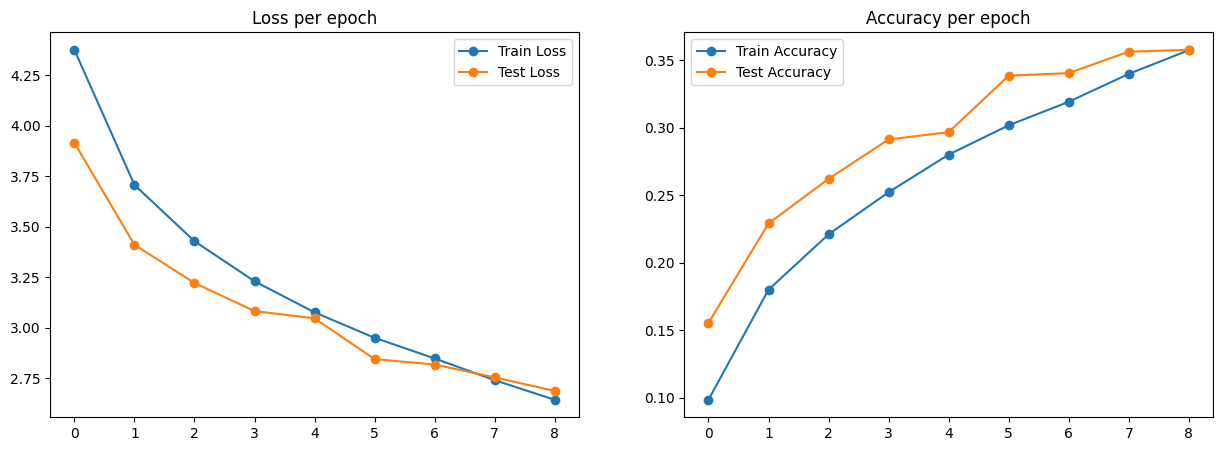

Saving best model

 		 ------------------------------ EPOCH: 10 ------------------------------
[22:58:01] Step 20/1407: train loss = 2.47945
[22:58:01] Step 40/1407: train loss = 2.4805
[22:58:02] Step 60/1407: train loss = 2.50826
[22:58:03] Step 80/1407: train loss = 2.53946
[22:58:04] Step 100/1407: train loss = 2.53791
[22:58:05] Step 120/1407: train loss = 2.53284
[22:58:06] Step 140/1407: train loss = 2.53137
[22:58:06] Step 160/1407: train loss = 2.52961
[22:58:07] Step 180/1407: train loss = 2.5305
[22:58:08] Step 200/1407: train loss = 2.52178
[22:58:09] Step 220/1407: train loss = 2.52076
[22:58:10] Step 240/1407: train loss = 2.51776
[22:58:10] Step 260/1407: train loss = 2.51956
[22:58:11] Step 280/1407: train loss = 2.52389
[22:58:12] Step 300/1407: train loss = 2.52468
[22:58:13] Step 320/1407: train loss = 2.52336
[22:58:14] Step 340/1407: train loss = 2.52061
[22:58:14] Step 360/1407: train loss = 2.52331
[22:58:15] Step 380/1407: train loss = 2.5207
[22:58:16] Step 400

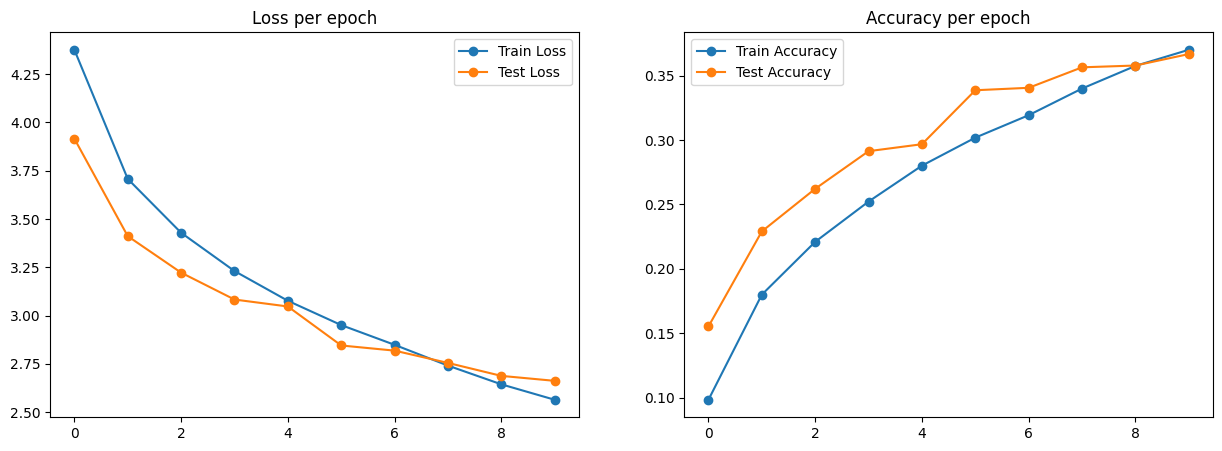

Saving best model

 		 ------------------------------ EPOCH: 11 ------------------------------
[22:59:02] Step 20/1407: train loss = 2.3401
[22:59:03] Step 40/1407: train loss = 2.38058
[22:59:04] Step 60/1407: train loss = 2.4069
[22:59:05] Step 80/1407: train loss = 2.41387
[22:59:06] Step 100/1407: train loss = 2.41199
[22:59:07] Step 120/1407: train loss = 2.4241
[22:59:07] Step 140/1407: train loss = 2.42169
[22:59:08] Step 160/1407: train loss = 2.41933
[22:59:09] Step 180/1407: train loss = 2.41716
[22:59:10] Step 200/1407: train loss = 2.42046
[22:59:11] Step 220/1407: train loss = 2.41404
[22:59:11] Step 240/1407: train loss = 2.41692
[22:59:12] Step 260/1407: train loss = 2.41418
[22:59:13] Step 280/1407: train loss = 2.41019
[22:59:14] Step 300/1407: train loss = 2.40658
[22:59:15] Step 320/1407: train loss = 2.40523
[22:59:15] Step 340/1407: train loss = 2.40775
[22:59:16] Step 360/1407: train loss = 2.4049
[22:59:17] Step 380/1407: train loss = 2.40781
[22:59:18] Step 400/

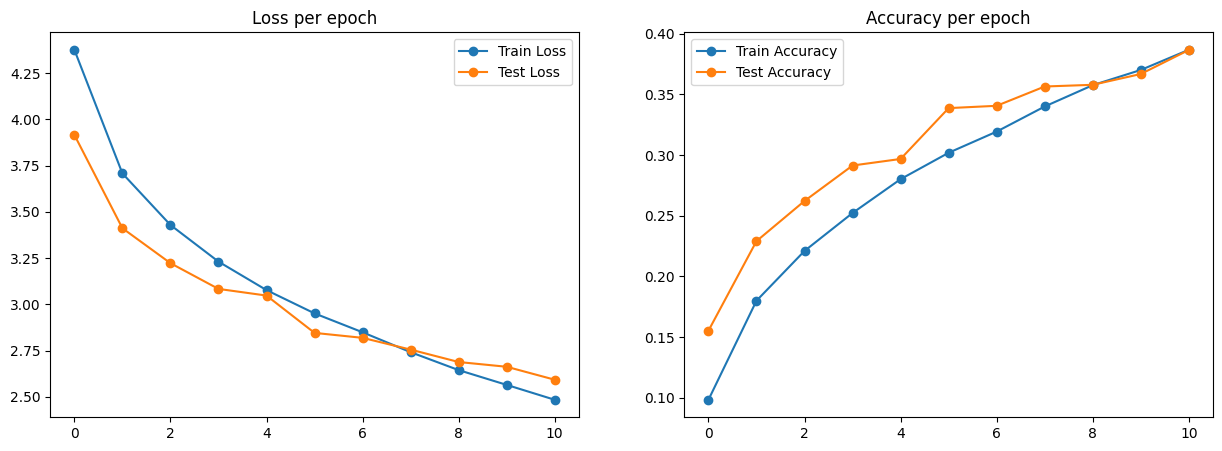

Saving best model

 		 ------------------------------ EPOCH: 12 ------------------------------
[23:00:04] Step 20/1407: train loss = 2.43876
[23:00:05] Step 40/1407: train loss = 2.41362
[23:00:06] Step 60/1407: train loss = 2.37477
[23:00:07] Step 80/1407: train loss = 2.36826
[23:00:07] Step 100/1407: train loss = 2.34088
[23:00:08] Step 120/1407: train loss = 2.33486
[23:00:09] Step 140/1407: train loss = 2.32963
[23:00:10] Step 160/1407: train loss = 2.33245
[23:00:11] Step 180/1407: train loss = 2.33175
[23:00:11] Step 200/1407: train loss = 2.33599
[23:00:12] Step 220/1407: train loss = 2.33982
[23:00:13] Step 240/1407: train loss = 2.34515
[23:00:14] Step 260/1407: train loss = 2.3481
[23:00:15] Step 280/1407: train loss = 2.35051
[23:00:16] Step 300/1407: train loss = 2.34931
[23:00:16] Step 320/1407: train loss = 2.35338
[23:00:17] Step 340/1407: train loss = 2.35756
[23:00:18] Step 360/1407: train loss = 2.3602
[23:00:19] Step 380/1407: train loss = 2.35972
[23:00:20] Step 40

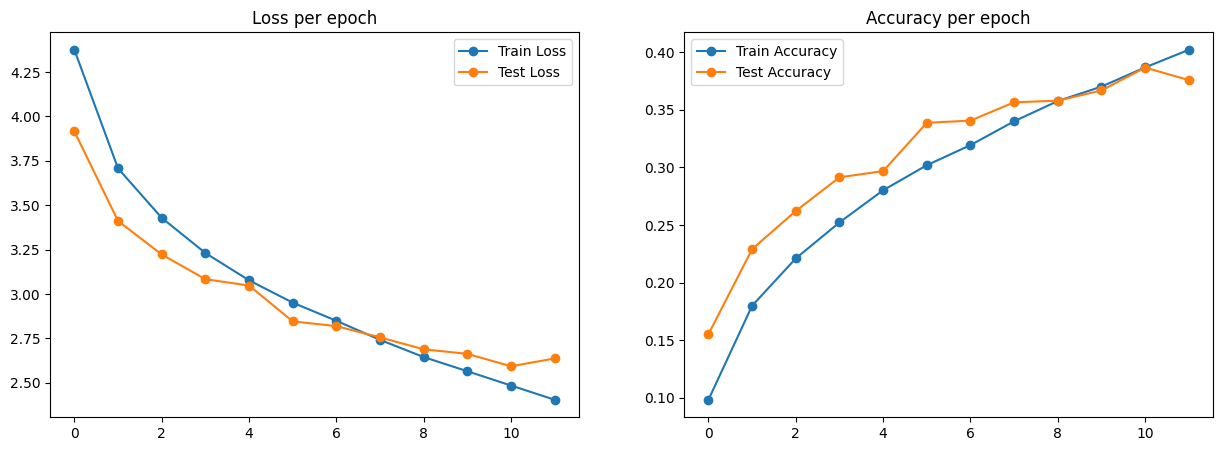

Validation loss didn't improve

 		 ------------------------------ EPOCH: 13 ------------------------------
[23:01:06] Step 20/1407: train loss = 2.28225
[23:01:07] Step 40/1407: train loss = 2.25907
[23:01:07] Step 60/1407: train loss = 2.28239
[23:01:08] Step 80/1407: train loss = 2.27346
[23:01:09] Step 100/1407: train loss = 2.27981
[23:01:10] Step 120/1407: train loss = 2.28269
[23:01:11] Step 140/1407: train loss = 2.27741
[23:01:11] Step 160/1407: train loss = 2.26968
[23:01:12] Step 180/1407: train loss = 2.26925
[23:01:13] Step 200/1407: train loss = 2.26719
[23:01:14] Step 220/1407: train loss = 2.27197
[23:01:15] Step 240/1407: train loss = 2.26998
[23:01:16] Step 260/1407: train loss = 2.27171
[23:01:16] Step 280/1407: train loss = 2.27443
[23:01:17] Step 300/1407: train loss = 2.27312
[23:01:18] Step 320/1407: train loss = 2.27042
[23:01:19] Step 340/1407: train loss = 2.27494
[23:01:20] Step 360/1407: train loss = 2.27501
[23:01:20] Step 380/1407: train loss = 2.27475
[23

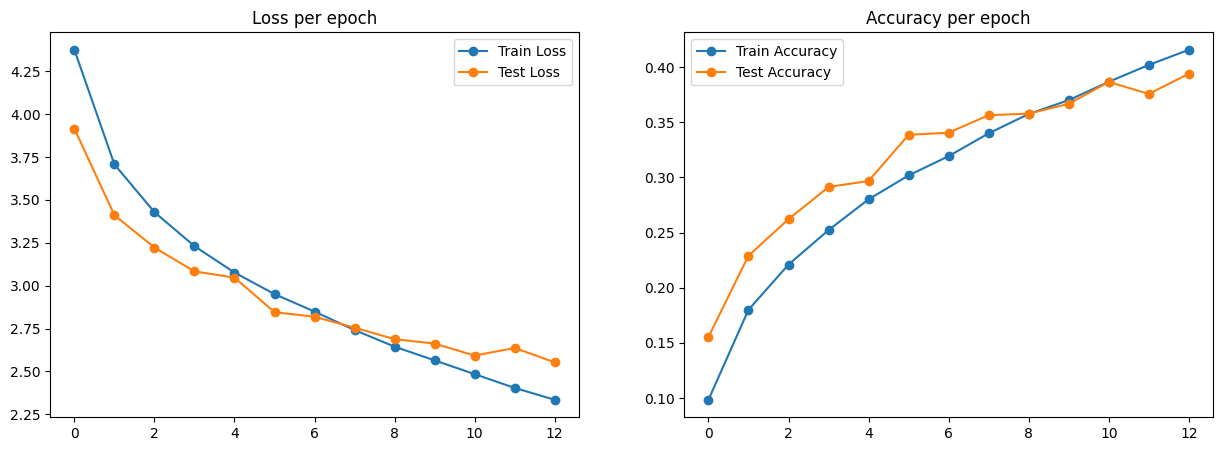

Saving best model

 		 ------------------------------ EPOCH: 14 ------------------------------
[23:02:08] Step 20/1407: train loss = 2.14923
[23:02:08] Step 40/1407: train loss = 2.13713
[23:02:09] Step 60/1407: train loss = 2.14596
[23:02:10] Step 80/1407: train loss = 2.14344
[23:02:11] Step 100/1407: train loss = 2.13785
[23:02:12] Step 120/1407: train loss = 2.13852
[23:02:12] Step 140/1407: train loss = 2.15869
[23:02:13] Step 160/1407: train loss = 2.16554
[23:02:14] Step 180/1407: train loss = 2.16656
[23:02:15] Step 200/1407: train loss = 2.17263
[23:02:16] Step 220/1407: train loss = 2.17725
[23:02:17] Step 240/1407: train loss = 2.18013
[23:02:17] Step 260/1407: train loss = 2.18264
[23:02:18] Step 280/1407: train loss = 2.1817
[23:02:19] Step 300/1407: train loss = 2.18299
[23:02:20] Step 320/1407: train loss = 2.18694
[23:02:21] Step 340/1407: train loss = 2.18722
[23:02:22] Step 360/1407: train loss = 2.19158
[23:02:22] Step 380/1407: train loss = 2.1917
[23:02:23] Step 40

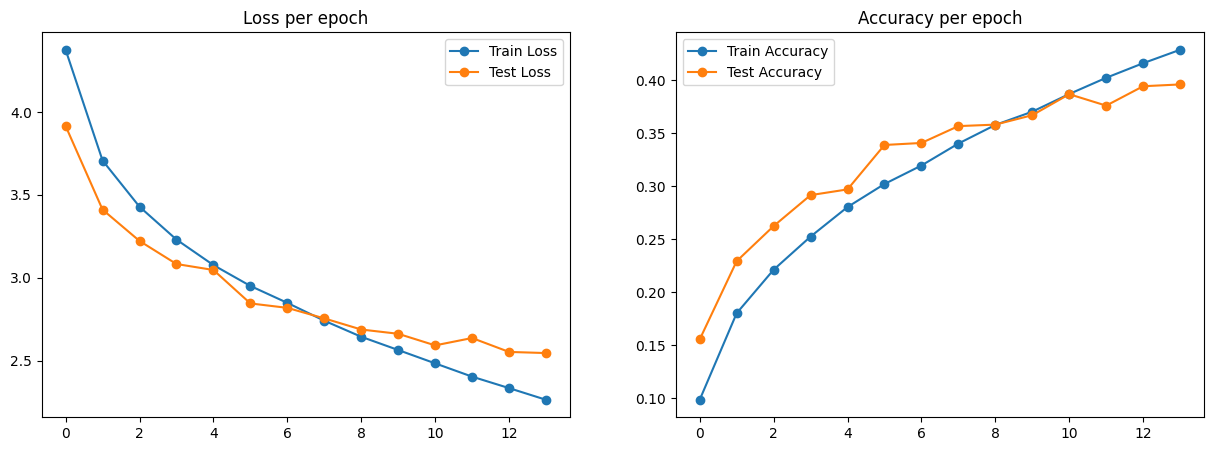

Saving best model

 		 ------------------------------ EPOCH: 15 ------------------------------
[23:03:10] Step 20/1407: train loss = 2.10678
[23:03:11] Step 40/1407: train loss = 2.09692
[23:03:11] Step 60/1407: train loss = 2.10226
[23:03:12] Step 80/1407: train loss = 2.09299
[23:03:13] Step 100/1407: train loss = 2.10342
[23:03:14] Step 120/1407: train loss = 2.11648
[23:03:15] Step 140/1407: train loss = 2.10961
[23:03:15] Step 160/1407: train loss = 2.11298
[23:03:16] Step 180/1407: train loss = 2.10921
[23:03:17] Step 200/1407: train loss = 2.10966
[23:03:18] Step 220/1407: train loss = 2.11215
[23:03:19] Step 240/1407: train loss = 2.11259
[23:03:19] Step 260/1407: train loss = 2.11238
[23:03:20] Step 280/1407: train loss = 2.11397
[23:03:21] Step 300/1407: train loss = 2.12108
[23:03:22] Step 320/1407: train loss = 2.12409
[23:03:23] Step 340/1407: train loss = 2.12282
[23:03:24] Step 360/1407: train loss = 2.12562
[23:03:24] Step 380/1407: train loss = 2.12981
[23:03:25] Step 

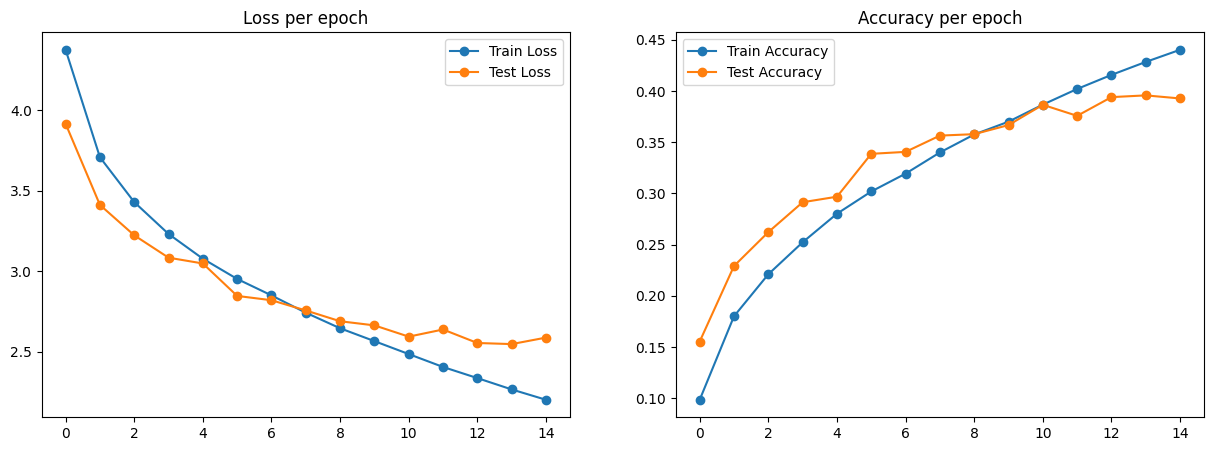

Validation loss didn't improve

 		 ------------------------------ EPOCH: 16 ------------------------------
[23:04:12] Step 20/1407: train loss = 2.04999
[23:04:13] Step 40/1407: train loss = 2.07281
[23:04:13] Step 60/1407: train loss = 2.06193
[23:04:14] Step 80/1407: train loss = 2.0486
[23:04:15] Step 100/1407: train loss = 2.04476
[23:04:16] Step 120/1407: train loss = 2.04205
[23:04:17] Step 140/1407: train loss = 2.04337
[23:04:17] Step 160/1407: train loss = 2.04865
[23:04:18] Step 180/1407: train loss = 2.03961
[23:04:19] Step 200/1407: train loss = 2.04755
[23:04:20] Step 220/1407: train loss = 2.05687
[23:04:21] Step 240/1407: train loss = 2.06237
[23:04:22] Step 260/1407: train loss = 2.05694
[23:04:22] Step 280/1407: train loss = 2.05881
[23:04:23] Step 300/1407: train loss = 2.05825
[23:04:24] Step 320/1407: train loss = 2.05919
[23:04:25] Step 340/1407: train loss = 2.06089
[23:04:26] Step 360/1407: train loss = 2.05984
[23:04:27] Step 380/1407: train loss = 2.05563
[23:

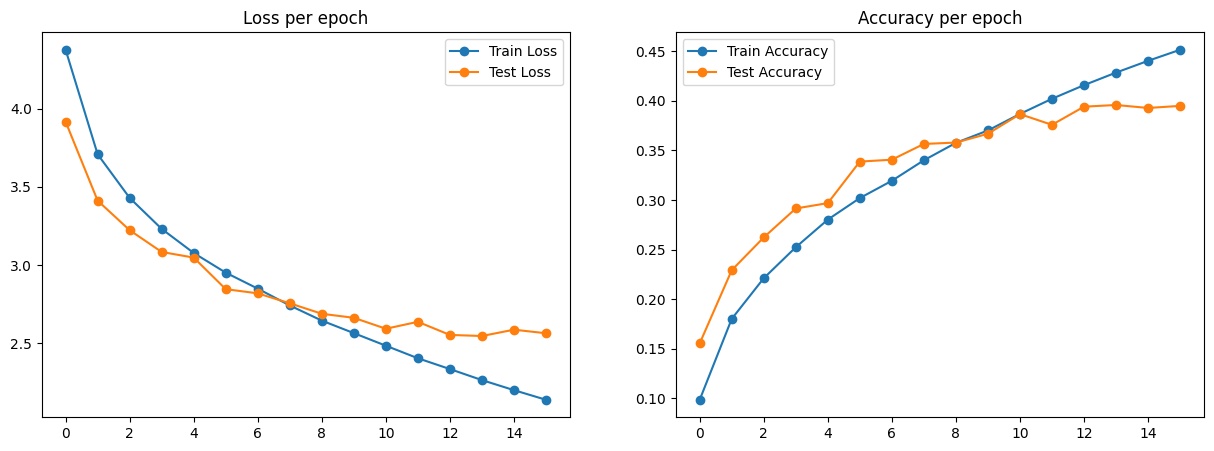

Validation loss didn't improve
EARLY STOPPING: min test_loss 2.54613, last 2 epochs min: 2.56372
Restoring the model at epoch 13: test_accuracy = 0.3958
Model successfully restored

 Training time: 16.0 minutes 29.88 seconds

 Final model is stored to model_epoch_13_test_acc_0.3958.pth


In [23]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}
t1 = monotonic()
for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-2:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-2:])}')
        print(f'Restoring the model at epoch {best_epoch}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break
t2 = monotonic()
m, s = divmod(t2 - t1, 60)
    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Training time: {m} minutes {round(s, 2)} seconds')
print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [24]:
import pandas as pd

In [25]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [26]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [27]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [28]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[23:05:14] Step 10/79 done
[23:05:15] Step 20/79 done
[23:05:15] Step 30/79 done
[23:05:16] Step 40/79 done
[23:05:16] Step 50/79 done
[23:05:17] Step 60/79 done
[23:05:17] Step 70/79 done


In [29]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,62
1,1,174
2,2,66
3,3,142
4,4,67


In [30]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [31]:
test_predictions_df['class'].value_counts()

class
142    93
11     91
10     90
140    87
111    87
       ..
106    20
36     19
166    18
60     15
167    12
Name: count, Length: 200, dtype: int64

In [32]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [33]:
test_predictions_df.head()

,ID,class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n09428293
2,val_2.JPEG,n03014705
3,val_3.JPEG,n02808440
4,val_4.JPEG,n03930313


In [34]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)